# Report without groud Truth v1.0

## Input prameters

In [2]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','h5_statistics','filtered_h5_statistics']

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)


no_gt_statistics_unfiltered = parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5')
no_gt_statistics_filtered = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5')

#print(no_gt_statistics_unfiltered)
#print(no_gt_statistics_filtered)

In [10]:
#%cd /data/mutect2/data_simulation/100x/170469/check_reporrt
#!pwd


In [35]:
# home=os.environ['HOME']
# sys.path.append('/home/ubuntu/proj1/VariantCalling/src/')
# from python.utils import revcomp
# from python.utils import revcomp

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

home=os.environ['HOME']
sys.path.append('/VariantCalling/src/')
from python.utils import revcomp


ModuleNotFoundError: No module named 'python'

In [36]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

In [11]:

af_hist = pd.read_hdf(no_gt_statistics_unfiltered,'af_hist')
ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_hete')
ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_homo')
motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')

filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered,'af_hist')
filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered,'ins_del_hete')
filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered,'ins_del_homo')
filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')
#eval
CompOverlap = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CompOverlap')
CountVariants = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CountVariants')
TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_unfiltered,'eval_TiTvVariantEvaluator')
IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
IndelSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelSummary')
MetricsCollection = pd.read_hdf(no_gt_statistics_unfiltered,'eval_MetricsCollection')
ValidationReport = pd.read_hdf(no_gt_statistics_unfiltered,'eval_ValidationReport')
VariantSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_VariantSummary')
MultiallelicSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_MultiallelicSummary')

filtered_CompOverlap = pd.read_hdf(no_gt_statistics_filtered,'eval_CompOverlap')
filtered_CountVariants = pd.read_hdf(no_gt_statistics_filtered,'eval_CountVariants')
filtered_TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_filtered,'eval_TiTvVariantEvaluator')
filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')
filtered_IndelSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelSummary')
filtered_MetricsCollection = pd.read_hdf(no_gt_statistics_filtered,'eval_MetricsCollection')
filtered_ValidationReport = pd.read_hdf(no_gt_statistics_filtered,'eval_ValidationReport')
filtered_VariantSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_VariantSummary')
filtered_MultiallelicSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_MultiallelicSummary')

In [12]:
#no_gt_statistics_unfiltered

In [13]:
#outplot_motif0 = pjoin(workdir, "motif0_bars.png")
#outplot_motif1 = pjoin(workdir, "motif1_plot.png")
#outplot_motif1_heatmap = pjoin(workdir, "motif1_heatmap.png")



## Allele Frequency histogram

In [14]:
def af_hist_graph(af_hist):
    nbins = 100
    bin_edges = pd.Series(np.linspace(0, 1, nbins))

    for group in af_hist.columns:

        plt.hist(af_hist[group],bin_edges, alpha=0.5, label=group) ##???
        plt.legend(loc='upper right')

    plt.show()


No handles with labels found to put in legend.


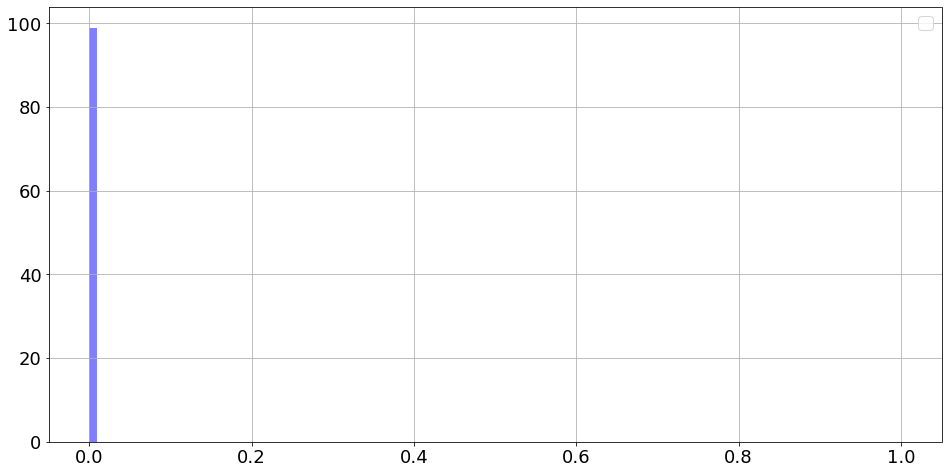

In [15]:
af_hist_graph(af_hist)

## Insertion Deletion Statistics

In [37]:
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")

## Heterozygous

In [38]:
ins_del_hete

,h-mer h-mer 1,h-mer h-mer 2,h-mer h-mer 3,h-mer h-mer 4,h-mer h-mer 5,h-mer h-mer 6,h-mer h-mer 7,h-mer h-mer 8,h-mer h-mer 9,h-mer h-mer 10,h-mer h-mer 11,h-mer h-mer 12
ins A,834,1084,1038,2873,1932,956,834,273,159,94,66,0
ins G,9604,7240,4774,2683,882,107,22,2,2,2,1,0
del A,0,1502,321,1396,2206,893,827,626,355,315,83,193
del G,0,8225,2306,4894,3714,1242,237,27,3,4,0,1


## Homozygous

In [39]:
ins_del_homo

,h-mer h-mer 1,h-mer h-mer 2,h-mer h-mer 3,h-mer h-mer 4,h-mer h-mer 5,h-mer h-mer 6,h-mer h-mer 7,h-mer h-mer 8,h-mer h-mer 9,h-mer h-mer 10,h-mer h-mer 11,h-mer h-mer 12
ins A,0,0,0,0,0,0,0,0,0,0,0,0
ins G,0,0,0,0,0,0,0,0,0,0,0,0
del A,0,0,0,0,0,0,0,0,0,0,0,0
del G,0,0,0,0,0,0,0,0,0,0,0,0


## Snp statistics

In [40]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    bbox_extra_artists = [
        plt.title(f"{x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=24)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}:{revcomp(ref)}->{alt}:{revcomp(alt)}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]")
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



# plt.savefig(
#     outplot_motif0, dpi=dpi, bbox_inches="tight", bbox_extra_artists=bbox_extra_artists
# )

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


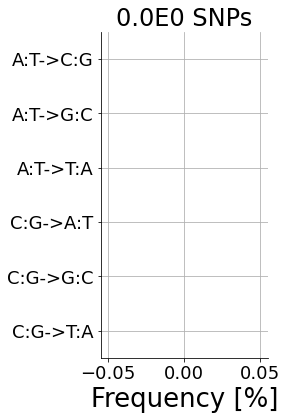

In [41]:
motifs_0 = motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]

bbox_extra_artists = plot_motifs0_bars(motifs_0)
#motifs_0

## Trinucleotide

In [42]:
def Trinucleotide_graph(motifs):
    bbox_extra_artists = list()
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1) + x["alt_1"] + x["ref_motif"].str.slice(2),
    )
    x = x.sort_values(["ref", "alt_1"]).reset_index()
    x["size"] *= 100
    x["size"].plot(color="b")  # .query("ref == 'A'")
    x.query("ref == 'C'")["size"].plot(color="r")
    plt.scatter(
        x.index,
        x["size"],
        color=[base_colors.get(v) for v in x["alt_1"]],
        alpha=1,
    )
    plt.xlim(-0.5, 95.5)
    plt.ylim(0, plt.gca().get_ylim()[1] + 1)
    plt.xticks([])
    bbox_extra_artists.append(plt.xlabel("Trinucleotide motif"))
    bbox_extra_artists.append(plt.ylabel("Frequency [%]"))

    th = x["size"].mean() + 2 * x["size"].std()
    for ind, row in x.iterrows():
        plt.text(
            ind - 0.35,
            row["size"] + 0.1,
            f"{row['ref_motif']}->{row['alt_motif']}",
            rotation=90,
            fontsize=10,
            alpha=1 if row["size"] > th else 0.3,
        )

    ax = plt.gca()
    plt.rcParams["font.family"] = "monospace"
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"] / 100).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    bbox_extra_artists.append(
        ax.text(
            1.025,
            0.5,
            table_str,
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
        )
    )
    plt.rcParams["font.family"] = "sans-serif"

    legend_elements = [
        Line2D([0], [0], color="b", lw=2, label="ref = A:T"),
        Line2D([0], [0], color="r", lw=2, label="ref = C:G"),
    ] + [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"alt = {k}:{revcomp(k)}",
            markerfacecolor=v,
            markersize=10,
        )
        for k, v in base_colors.items()
    ]
    bbox_extra_artists.append(plt.legend(handles=legend_elements, bbox_to_anchor=[1.01, 1]))



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

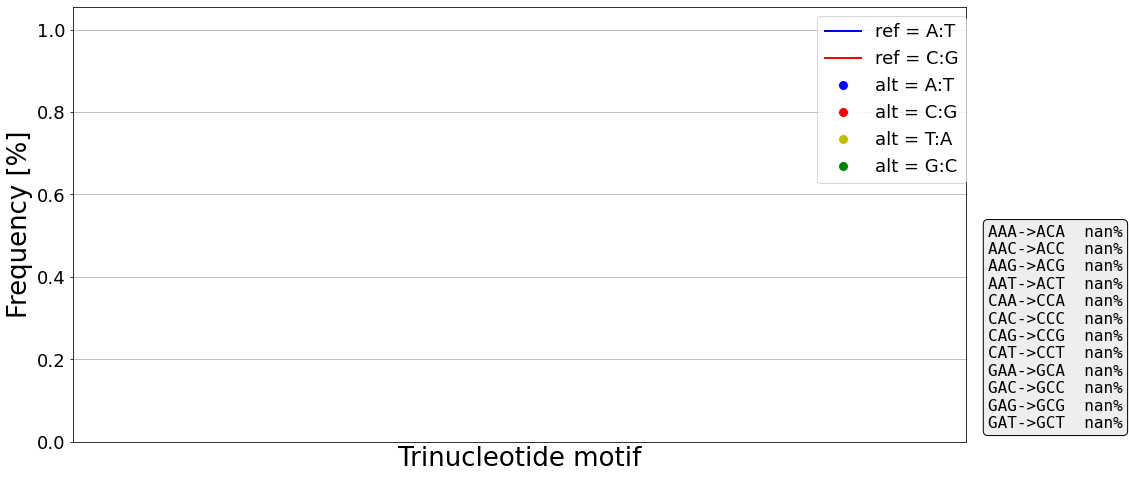

In [43]:
Trinucleotide_graph(motifs)

## Heatmap

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


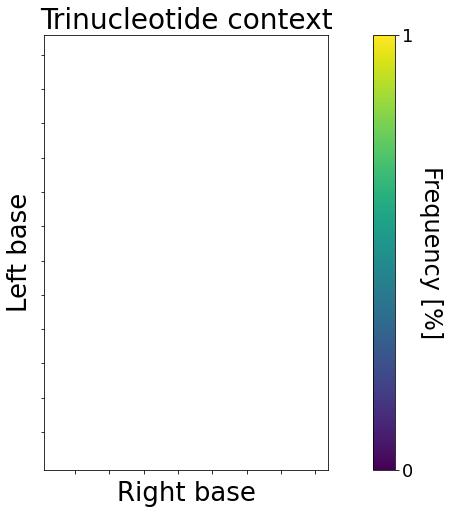

In [44]:
def plot_heatmap(motifs,ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title("Trinucleotide context", fontsize=28)
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}:{revcomp(y['ref'])}->{y['alt_1']}:{revcomp(y['alt_1'])}",
            axis=1,
        )
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
        )
    )
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")

plot_heatmap(motifs)


# Filtered

## Allele Frequency histogram

No handles with labels found to put in legend.


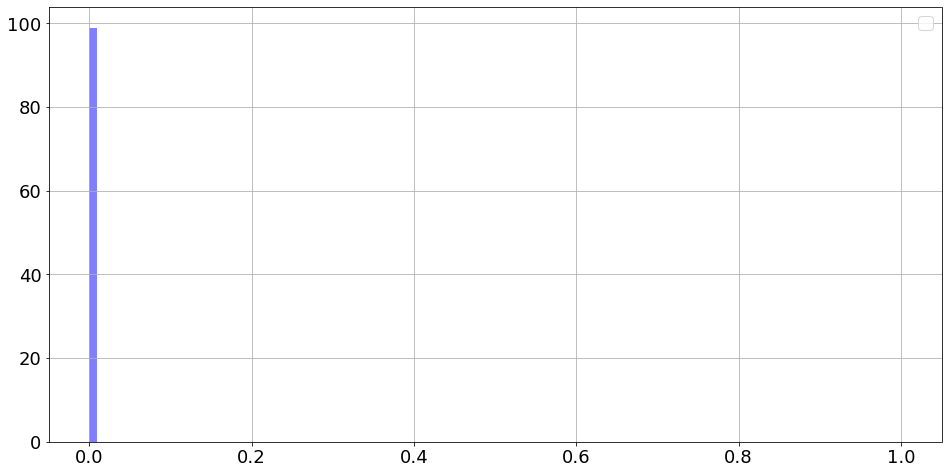

In [45]:
af_hist_graph(filtered_af_hist)

## Insertion Deletion Statistics

In [46]:
filtered_ins_del_hete.columns = pd.Series(filtered_ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
filtered_ins_del_homo.columns = pd.Series(filtered_ins_del_homo.columns).apply(lambda x: f"h-mer {x}")

## Heterozygous

In [47]:
filtered_ins_del_hete

,h-mer 1,h-mer 2,h-mer 3,h-mer 4,h-mer 5,h-mer 6,h-mer 7,h-mer 8,h-mer 9,h-mer 10,h-mer 11,h-mer 12
ins A,834,1084,1038,2873,1932,956,834,273,159,94,66,0
ins G,9604,7240,4774,2683,882,107,22,2,2,2,1,0
del A,0,1502,321,1396,2206,893,827,626,355,315,83,193
del G,0,8225,2306,4894,3714,1242,237,27,3,4,0,1


## Homozygous

In [48]:
filtered_ins_del_homo

,h-mer 1,h-mer 2,h-mer 3,h-mer 4,h-mer 5,h-mer 6,h-mer 7,h-mer 8,h-mer 9,h-mer 10,h-mer 11,h-mer 12
ins A,0,0,0,0,0,0,0,0,0,0,0,0
ins G,0,0,0,0,0,0,0,0,0,0,0,0
del A,0,0,0,0,0,0,0,0,0,0,0,0
del G,0,0,0,0,0,0,0,0,0,0,0,0


## Snp statistics

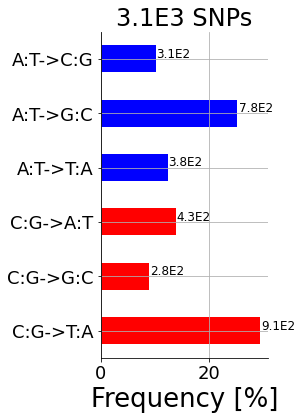

In [49]:
motifs_0 = filtered_motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]

bbox_extra_artists = plot_motifs0_bars(motifs_0)

## Trinucleotide

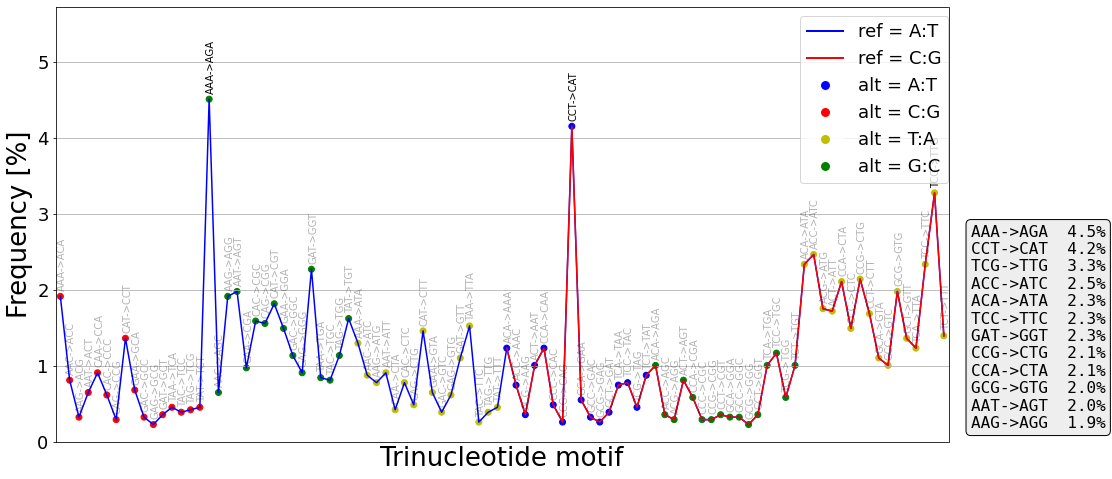

In [50]:
Trinucleotide_graph(filtered_motifs)

## Heatmap

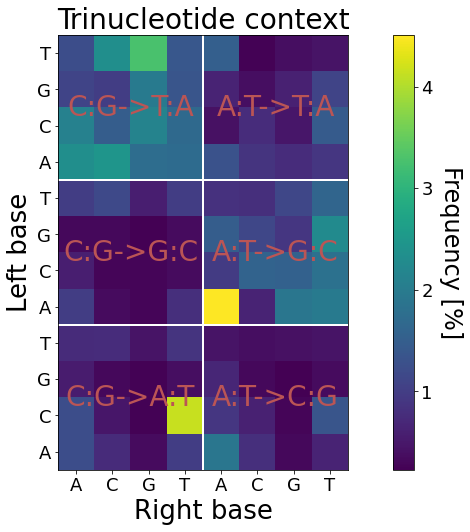

In [51]:
plot_heatmap(filtered_motifs)

# Statistics tables from VariantEval

## CompOverlap

In [52]:
CompOverlap = CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CompOverlap.columns = pd.Series(CompOverlap.iloc[0])
unfiltered = CompOverlap[1::].loc[["nEvalVariants","novelSites"]]

filtered_CompOverlap = filtered_CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CompOverlap.columns = pd.Series(filtered_CompOverlap.iloc[0])
filtered = filtered_CompOverlap[1::].loc[["nEvalVariants","novelSites"]]
filtered.rename({"nEvalVariants": "filtered_nEvalVariants", "novelSites": "filtered_novelSites"}, axis='index',inplace=True)

unfiltered.append(filtered)
## concordantRate

Novelty,all,known,novel
nEvalVariants,173361,5301,168060
novelSites,168060,0,168060
filtered_nEvalVariants,3981,994,2987
filtered_novelSites,2987,0,2987


## CountVariants

In [53]:
CountVariants = CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CountVariants.columns = pd.Series(CountVariants.iloc[0])
unfiltered = CountVariants[1::].loc[["nDeletions","nInsertions"]]

filtered_CountVariants = filtered_CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CountVariants.columns = pd.Series(filtered_CountVariants.iloc[0])
filtered = filtered_CountVariants[1::].loc[["nDeletions","nInsertions"]]
filtered.rename({"nDeletions": "filtered_nDeletions", "nInsertions": "filtered_nInsertions"}, axis='index',inplace=True)

unfiltered.append(filtered)

Novelty,all,known,novel
nDeletions,53607,1232,52375
nInsertions,56051,574,55477
filtered_nDeletions,441,74,367
filtered_nInsertions,291,35,256


## TiTvVariantEvaluator

In [54]:
TiTvVariantEvaluator = TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
TiTvVariantEvaluator.columns = pd.Series(TiTvVariantEvaluator.iloc[0])
unfiltered = TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]

filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_TiTvVariantEvaluator.columns = pd.Series(filtered_TiTvVariantEvaluator.iloc[0])
filtered = filtered_TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]
filtered.rename({"nTi": "filtered_nTi", "nTv": "filtered_nTv", "TiTvRatioStandard": "filtered_TiTvRatioStandard"}, axis='index',inplace=True)

unfiltered.append(filtered)

Novelty,all,known,novel
nTi,12713,1358,11355
nTv,50066,2047,48019
TiTvRatioStandard,2.00,1.80,2.00
filtered_nTi,1654,536,1118
filtered_nTv,1343,301,1042
filtered_TiTvRatioStandard,2.00,1.90,2.00


## IndelSummary

In [55]:
IndelSummary = IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
IndelSummary.columns = pd.Series(IndelSummary.iloc[0])
unfiltered = IndelSummary[1::].loc[["indel_novelty_rate",
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "SNP_het_to_hom_ratio",
                       "indel_het_to_hom_ratio"]]

filtered_IndelSummary = filtered_IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_IndelSummary.columns = pd.Series(filtered_IndelSummary.iloc[0])
filtered = filtered_IndelSummary[1::].loc[["indel_novelty_rate",
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "SNP_het_to_hom_ratio",
                       "indel_het_to_hom_ratio"]]

filtered.rename({"SNP_het_to_hom_ratio": "filtered_SNP_het_to_hom_ratio",
                 "SNP_to_indel_ratio": "filtered_SNP_to_indel_ratio",
                 "SNP_het_to_hom_ratio": "filtered_SNP_het_to_hom_ratio",
                 "indel_het_to_hom_ratio": "filtered_indel_het_to_hom_ratio"}, axis='index',inplace=True)
unfiltered.append(filtered)

Novelty,all,known,novel
indel_novelty_rate,98.24,0.00,100.00
SNP_het_to_hom_ratio,NA,NA,NA
SNP_to_indel_ratio,0.57,1.77,0.55
SNP_het_to_hom_ratio,NA,NA,NA
indel_het_to_hom_ratio,NA,NA,NA
indel_novelty_rate,81.14,0.00,100.00
filtered_SNP_het_to_hom_ratio,NA,NA,NA
filtered_SNP_to_indel_ratio,3.41,4.97,3.05
filtered_SNP_het_to_hom_ratio,NA,NA,NA
filtered_indel_het_to_hom_ratio,NA,NA,NA


## MultiallelicSummary

In [56]:
MultiallelicSummary = MultiallelicSummary.drop(["MultiallelicSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
MultiallelicSummary.columns = pd.Series(MultiallelicSummary.iloc[0])
unfiltered = MultiallelicSummary[1::].loc[["nTi","nTv"]]

filtered_MultiallelicSummary = filtered_MultiallelicSummary.drop(["MultiallelicSummary",
                                                                  "CompFeatureInput",
                                                                  "EvalFeatureInput",
                                                                  "JexlExpression"], axis=1).transpose()
filtered_MultiallelicSummary.columns = pd.Series(filtered_MultiallelicSummary.iloc[0])
filtered = filtered_MultiallelicSummary[1::].loc[["nTi","nTv"]]
filtered.rename({"nTi": "filtered_nTi",
                 "nTv": "filtered_nTv"}, axis='index',inplace=True)
unfiltered.append(filtered)

Novelty,all,known,novel
nTi,79,13,66
nTv,145,25,120
filtered_nTi,59,11,48
filtered_nTv,113,21,92


## IndelLengthHistogram

In [57]:
IndelLengthHistogram

,IndelLengthHistogram,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,Length,Freq
0,IndelLengthHistogram,dbsnp,eval,none,all,-10,0.00
1,IndelLengthHistogram,dbsnp,eval,none,all,-9,0.00
2,IndelLengthHistogram,dbsnp,eval,none,all,-8,0.00
3,IndelLengthHistogram,dbsnp,eval,none,all,-7,0.00
4,IndelLengthHistogram,dbsnp,eval,none,all,-6,0.00
5,IndelLengthHistogram,dbsnp,eval,none,all,-5,0.00
6,IndelLengthHistogram,dbsnp,eval,none,all,-4,0.00
7,IndelLengthHistogram,dbsnp,eval,none,all,-3,0.00
8,IndelLengthHistogram,dbsnp,eval,none,all,-2,0.04
9,IndelLengthHistogram,dbsnp,eval,none,all,-1,0.44


<!--  ## MetricsCollection -->

In [58]:
# MetricsCollection = MetricsCollection.drop(["MetricsCollection","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
# MetricsCollection.columns = pd.Series(MetricsCollection.iloc[0])
# MetricsCollection[1::]

<!-- ## ValidationReport -->

In [93]:
# ValidationReport = ValidationReport.drop(["ValidationReport","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
# ValidationReport.columns = pd.Series(ValidationReport.iloc[0])
# ValidationReport[1::]

<!--  ## VariantSummary -->

In [94]:
# VariantSummary = VariantSummary.drop(["VariantSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
# VariantSummary.columns = pd.Series(VariantSummary.iloc[0])
# VariantSummary[1::]